# Data import

In [1]:
import sys
sys.path.append(r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis")

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


In [9]:
import inspect
from flexynesis import DataImporter

print(inspect.getfile(DataImporter))

from flexynesis import DataImporter

data_importer = DataImporter(
    path=r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1",
    data_types=['LD', 'PM', 'BM', 'HDF'],  # 四个数据集的名称，要和文件名对应
    concatenate=False,  # 根据你需求决定是否合并特征，通常False
    top_percentile=100,  # Laplacian选出前10%特征
    min_features=100,   # 至少保留100个特征
    variance_threshold=0.0,  # 80%的方差阈值
    # correlation_threshold=0.9,  # 如果需要可以打开
)

train_dataset, test_dataset, whole_dataset = data_importer.import_data()


C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\data.py

[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\clin.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\LD.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\HDF.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\PM.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\BM.csv...

[INFO] ------------

#  Model training

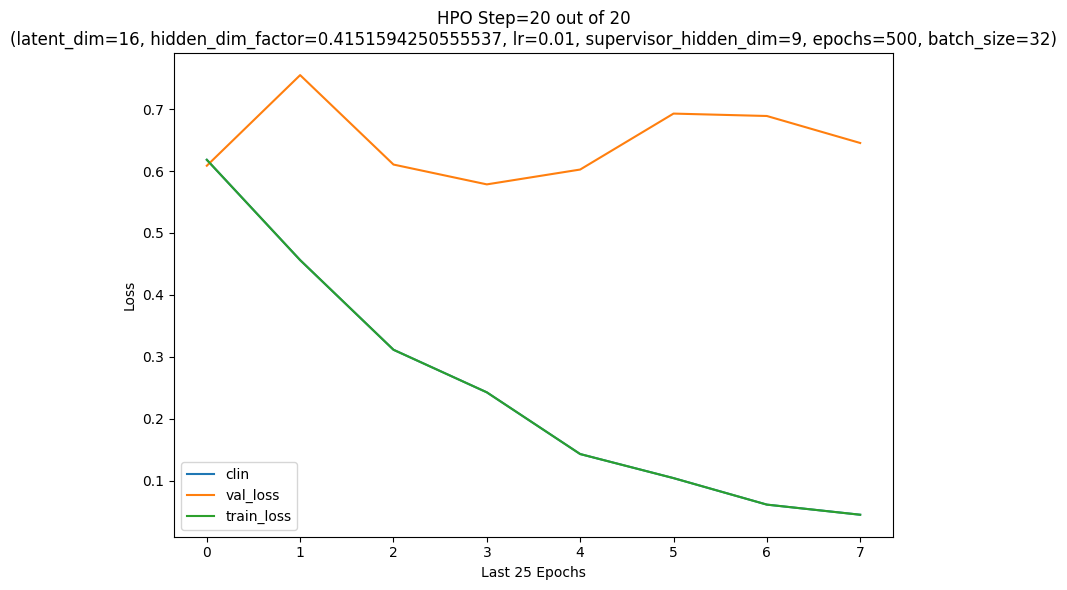

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │     0.645429253578186     │
│         val_loss          │     0.645429253578186     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 20/20 [12:59<00:00, 38.96s/it, Iteration=20, Best Loss=0.235]

[INFO] current best val loss: 0.23480439186096191; best params: {'latent_dim': 16, 'hidden_dim_factor': 0.42957188553008957, 'lr': 0.002715634878132377, 'supervisor_hidden_dim': 20, 'epochs': 500, 'batch_size': 32} since 2 hpo iterations


In [64]:
# early stopping -  tune the best parameters
tuner = flexynesis.HyperparameterTuning(
    dataset = train_dataset,                # training dataset
    model_class = flexynesis.DirectPred,   # model selection
    target_variables = ["clin"],# outcome variable
    config_name = "DirectPred",             
    n_iter=20,                              # how many time the hyperparameters are trained
    plot_losses=True,                      # open the losss ploting function
    early_stop_patience=4                 # if didn't go up  in 4 epochs, stop
)

model, best_params = tuner.perform_tuning()  


In [80]:
model

DirectPred(
  (log_vars): ParameterDict(  (clin): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=904, out_features=388, bias=True)
      (layer_out): Linear(in_features=388, out_features=16, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(388, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=501, out_features=215, bias=True)
      (layer_out): Linear(in_features=215, out_features=16, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(215, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MLP(
      (layer_1): Linear(in_features=1149, out_features=493, bias=True)
      (layer_out): Linear(in_features=493, out_features=16, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inpl

In [82]:
best_params

{'latent_dim': 16,
 'hidden_dim_factor': 0.42957188553008957,
 'lr': 0.002715634878132377,
 'supervisor_hidden_dim': 20,
 'epochs': 13,
 'batch_size': 32}

# Prediction 

In [15]:
y_pred_dict = model.predict(test_dataset)
metrics_df = flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=y_pred_dict, dataset = test_dataset)
metrics_df

⚠️ Warning: All variables are forcibly treated as categorical during evaluation.


,method,var,variable_type,metric,value
0,DirectPred,clin,categorical,balanced_acc,0.916109
1,DirectPred,clin,categorical,f1_score,0.917555
2,DirectPred,clin,categorical,kappa,0.833845
3,DirectPred,clin,categorical,average_auroc,0.957637
4,DirectPred,clin,categorical,average_aupr,0.939479


# Feature selection

In [150]:
feature_importance_train= model.compute_feature_importance(
    dataset=train_dataset,
    target_var="clin",
    method="GradientShap",       #  这里你选择 GradientShap
    steps_or_samples=10,         # 可选，控制精度，默认是 5
    batch_size=32                # 可选，默认是 64
)
feature_importance_train

,target_variable,target_class,target_class_label,layer,name,importance
0,clin,0,DM,HDF,HDF38768_HDF,0.001073
1,clin,0,DM,HDF,HDF38296_HDF,0.001913
2,clin,0,DM,HDF,HDF57814_HDF,0.001584
3,clin,0,DM,HDF,HDF48762_HDF,0.001442
4,clin,0,DM,HDF,HDF52603_HDF,0.003972
...,...,...,...,...,...,...
5425,clin,1,nonDM,BM,BM0159_BM,0.007176
5426,clin,1,nonDM,BM,BM0160_BM,0.008103
5427,clin,1,nonDM,BM,BM0161_BM,0.004659
5428,clin,1,nonDM,BM,BM0162_BM,0.006348


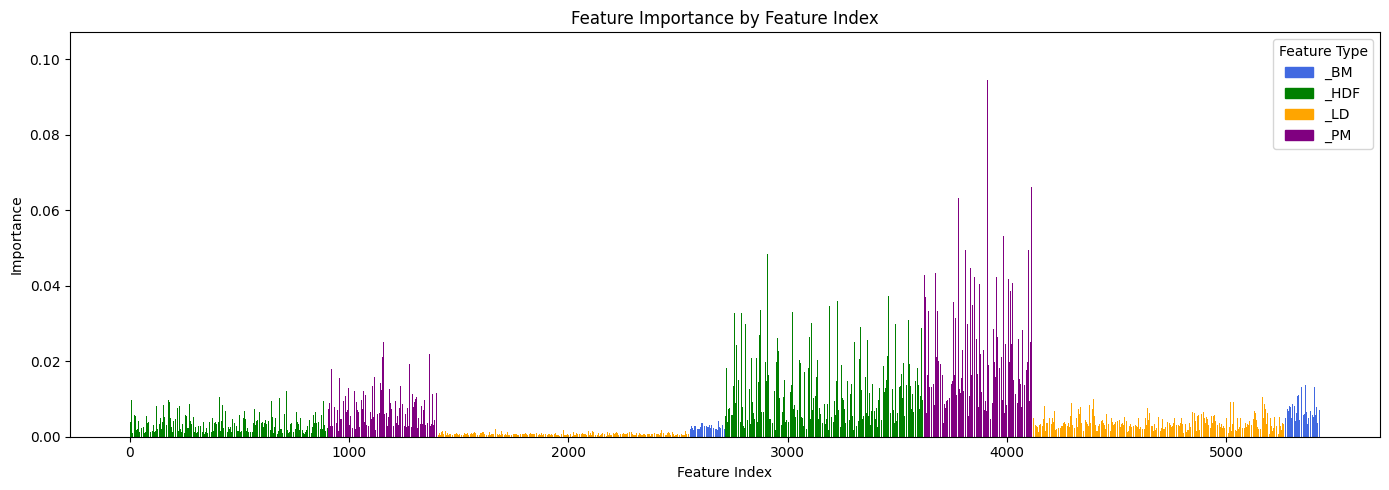

In [152]:
import matplotlib.pyplot as plt

def plot_feature_importance_bar(df, figsize=(14,5), title='Feature Importance by Feature Index'):
    df = df.reset_index(drop=True)
    df['feature_index'] = df.index

    # 提取特征后缀
    def get_suffix(name):
        for suffix in ['_BM', '_HDF', '_LD', '_PM']:
            if name.endswith(suffix):
                return suffix
        return 'Other'

    df['suffix'] = df['name'].apply(get_suffix)

    # 给每种后缀设颜色
    color_dict = {
        '_BM': 'royalblue',
        '_HDF': 'green',
        '_LD': 'orange',
        '_PM': 'purple',
    }

    df['color'] = df['suffix'].map(color_dict)

    plt.figure(figsize=figsize)
    
    # 画柱状图，每根柱子颜色根据block区分
    plt.bar(df['feature_index'], df['importance'], color=df['color'], edgecolor='none')

    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title(title)
    # 自定义图例
    handles = [plt.Rectangle((0,0),1,1,color=color_dict[key]) for key in color_dict]
    labels = list(color_dict.keys())
    plt.legend(handles, labels, title='Feature Type')
    
    plt.tight_layout()
    plt.show()

# 调用示例
plot_feature_importance_bar(feature_importance_train)


In [17]:
feature_importance= model.compute_feature_importance(
    dataset=whole_dataset,
    target_var="clin",
    method="GradientShap",       #  这里你选择 GradientShap
    steps_or_samples=10,         # 可选，控制精度，默认是 5
    batch_size=32                # 可选，默认是 64
)
feature_importance

,target_variable,target_class,target_class_label,layer,name,importance
0,clin,0,DM,HDF,HDF38768_HDF,0.002890
1,clin,0,DM,HDF,HDF38296_HDF,0.004125
2,clin,0,DM,HDF,HDF57814_HDF,0.003014
3,clin,0,DM,HDF,HDF48762_HDF,0.007788
4,clin,0,DM,HDF,HDF52603_HDF,0.010300
...,...,...,...,...,...,...
5425,clin,1,nonDM,BM,BM0159_BM,0.006936
5426,clin,1,nonDM,BM,BM0160_BM,0.006878
5427,clin,1,nonDM,BM,BM0161_BM,0.002791
5428,clin,1,nonDM,BM,BM0162_BM,0.007753


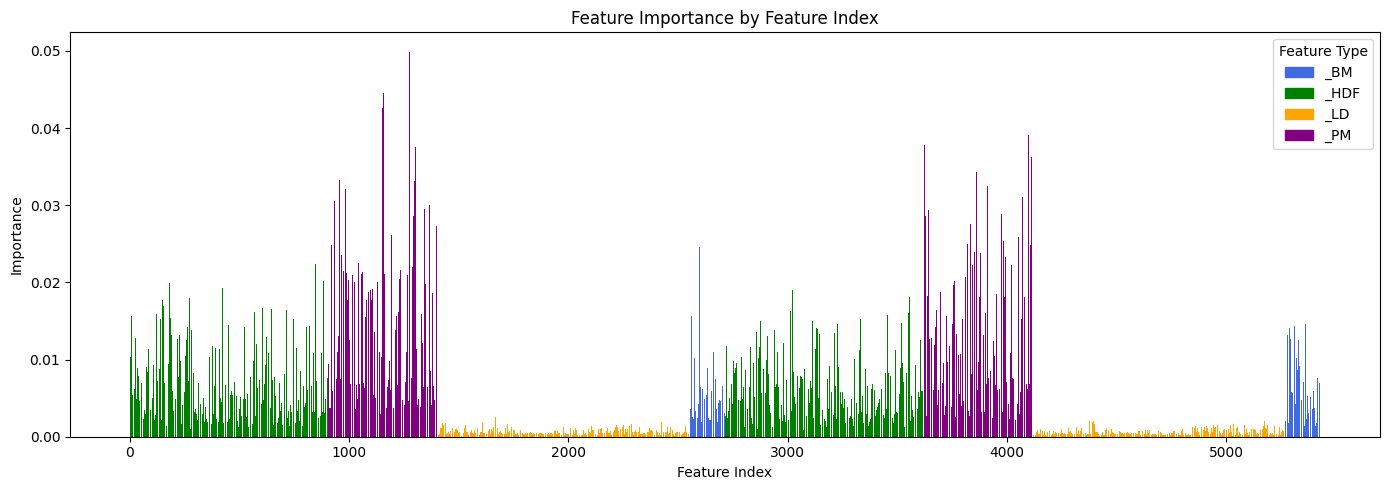

In [94]:
import matplotlib.pyplot as plt

def plot_feature_importance_bar(df, figsize=(14,5), title='Feature Importance by Feature Index'):
    df = df.reset_index(drop=True)
    df['feature_index'] = df.index

    # 提取特征后缀
    def get_suffix(name):
        for suffix in ['_BM', '_HDF', '_LD', '_PM']:
            if name.endswith(suffix):
                return suffix
        return 'Other'

    df['suffix'] = df['name'].apply(get_suffix)

    # 给每种后缀设颜色
    color_dict = {
        '_BM': 'royalblue',
        '_HDF': 'green',
        '_LD': 'orange',
        '_PM': 'purple',
    }

    df['color'] = df['suffix'].map(color_dict)

    plt.figure(figsize=figsize)
    
    # 画柱状图，每根柱子颜色根据block区分
    plt.bar(df['feature_index'], df['importance'], color=df['color'], edgecolor='none')

    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title(title)
    # 自定义图例
    handles = [plt.Rectangle((0,0),1,1,color=color_dict[key]) for key in color_dict]
    labels = list(color_dict.keys())
    plt.legend(handles, labels, title='Feature Type')
    
    plt.tight_layout()
    plt.show()

# 调用示例
plot_feature_importance_bar(feature_importance)


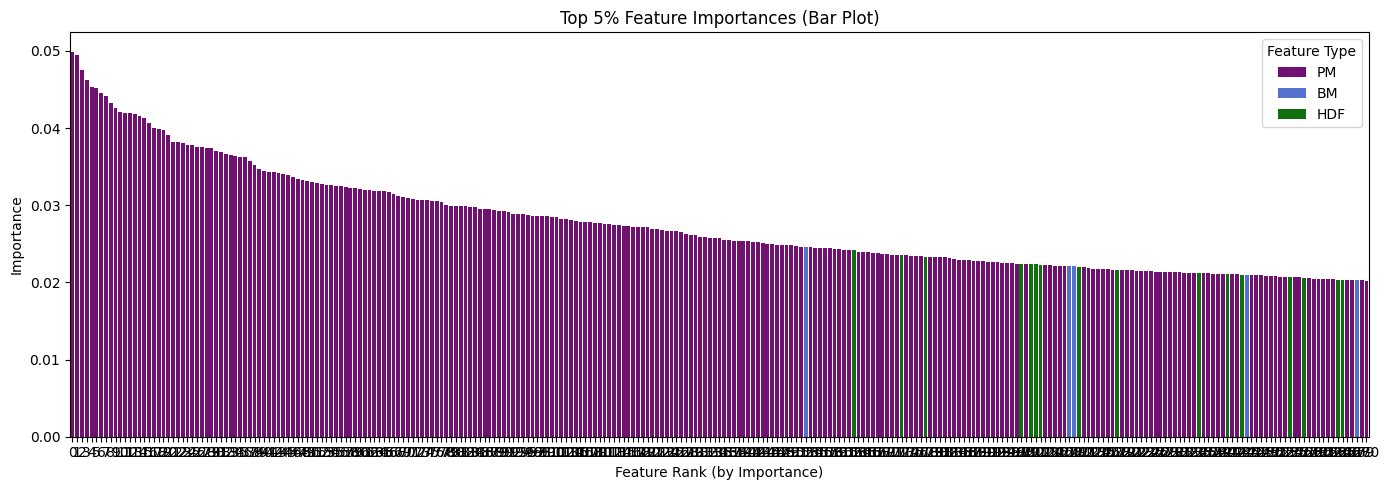

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance_bar(df, top_percent=0.01, figsize=(14,5), title=None):
    """
    画柱状图，显示 top_percent 特征的重要性，颜色区分 feature_type。

    参数：
        df (pd.DataFrame): 含 'name' 和 'importance' 列
        top_percent (float): 展示的前多少比例特征
        figsize (tuple): 图尺寸
        title (str): 图标题
    """
    # 按 importance 排序
    df_sorted = df.sort_values('importance', ascending=False).reset_index(drop=True)
    
    top_n = int(len(df_sorted) * top_percent)
    df_top = df_sorted.iloc[:top_n].copy()
    df_top['feature_rank'] = df_top.index

    # 提取后缀作为 feature_type
    def get_suffix(name):
        for suffix in ['_BM', '_HDF', '_LD', '_PM']:
            if name.endswith(suffix):
                return suffix[1:]
        return 'Other'

    df_top['feature_type'] = df_top['name'].apply(get_suffix)

    # 画柱状图
    plt.figure(figsize=figsize)
    sns.barplot(
        data=df_top,
        x='feature_rank',
        y='importance',
        hue='feature_type',
        palette={'BM':'royalblue', 'HDF':'green', 'LD':'orange', 'PM':'purple', 'Other':'gray'},
        dodge=False
    )
    plt.xlabel('Feature Rank (by Importance)')
    plt.ylabel('Importance')
    if title is None:
        title = f'Top {int(top_percent*100)}% Feature Importances (Bar Plot)'
    plt.title(title)
    plt.legend(title='Feature Type')
    plt.tight_layout()
    plt.show()

    return df_top[['name', 'feature_type', 'importance']]
    
# 用法示例
top_features=plot_feature_importance_bar(feature_importance, top_percent=0.05)


In [122]:
top_features

,name,feature_type,importance
0,PM33163_PM,PM,0.049909
1,PM39518_PM,PM,0.049442
2,PM38002_PM,PM,0.047481
3,PM34732_PM,PM,0.046190
4,PM33163_PM,PM,0.045259
...,...,...,...
266,PM35136_PM,PM,0.020318
267,PM32632_PM,PM,0.020286
268,BM0037_BM,BM,0.020268
269,PM34389_PM,PM,0.020260


# Permultation test

In [70]:
# Permutation coding
import time
import torch
import pandas as pd
from tqdm import trange
import flexynesis  # 确保import了这个
import matplotlib.pyplot as plt
import seaborn as sns

def feature_importance_permutation_test(
    model,
    whole_dataset,
    target_var="clin",
    method="GradientShap",
    steps_or_samples=10,
    batch_size=32,
    n_permutations=10,
    model_class=flexynesis.DirectPred,
    config_name="DirectPred",
    early_stop_patience=4,
    n_iter=2,
):
    start_time = time.time()
    print(f"[INFO] Permutation test started at {time.strftime('%Y-%m-%d %H:%M:%S')}")

    # 1) 原始 importance
    df_obs = model.compute_feature_importance(
        dataset=whole_dataset,
        target_var=target_var,
        method=method,
        steps_or_samples=steps_or_samples,
        batch_size=batch_size
    )
    obs_imp = df_obs.set_index('name')['importance']

    all_perm = pd.DataFrame(index=obs_imp.index)
    y_orig = whole_dataset.ann[target_var].clone()
    n = len(y_orig)

    for i in trange(n_permutations, desc="Permutations"):
        # 1. 打乱标签
        idx = torch.randperm(n)
        whole_dataset.ann[target_var] = y_orig[idx]

        # 2. retrain 模型
        tuner = flexynesis.HyperparameterTuning(
            dataset=whole_dataset,
            model_class=model_class,
            target_variables=[target_var],
            config_name=config_name,
            n_iter=n_iter,
            plot_losses=False,
            early_stop_patience=early_stop_patience,
        )
        perm_model, _ = tuner.perform_tuning()

        # 3. 计算 permuted importance
        df_p = perm_model.compute_feature_importance(
            dataset=whole_dataset,
            target_var=target_var,
            method=method,
            steps_or_samples=steps_or_samples,
            batch_size=batch_size
        )
        perm_imp = df_p.set_index('name')['importance']
        all_perm[f"perm_{i}"] = perm_imp

    # 4. 恢复标签
    whole_dataset.ann[target_var] = y_orig

    # 5. 统计 p-value
    ge = (all_perm.ge(obs_imp, axis=0)).sum(axis=1)
    p_values = ge / n_permutations

    df_pval = pd.DataFrame({
        'feature': obs_imp.index,
        'obs_importance': obs_imp.values,
        'p_value': p_values.values
    }).reset_index(drop=True)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"[INFO] Permutation test finished at {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"[INFO] Total elapsed time: {elapsed:.2f} seconds")

    return df_pval, all_perm




Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.7001503705978394     │
│         val_loss          │    0.7001503705978394     │
└───────────────────────────┴───────────────────────────┘


Tuning Progress: 100%|██████████| 5/5 [03:03<00:00, 36.65s/it, Iteration=5, Best Loss=0.68]


[INFO] current best val loss: 0.6802211999893188; best params: {'latent_dim': 115, 'hidden_dim_factor': 0.22781155955163535, 'lr': 0.00018620000098871638, 'supervisor_hidden_dim': 23, 'epochs': 500, 'batch_size': 128} since 4 hpo iterations


C:\Users\laura\AppData\Local\Temp\ipykernel_30164\3616869886.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
Permutations: 100%|██████████| 200/200 [11:24:14<00:00, 205.27s/it]


[INFO] Permutation test finished at 2025-06-20 00:29:17
[INFO] Total elapsed time: 41055.72 seconds
        feature  obs_importance  p_value
0  HDF38768_HDF        0.000864    0.995
1  HDF38296_HDF        0.001224    0.995
2  HDF57814_HDF        0.001412    0.995
3  HDF48762_HDF        0.001224    1.000
4  HDF52603_HDF        0.003976    0.905


C:\Users\laura\AppData\Local\Temp\ipykernel_30164\3616869886.py:107: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


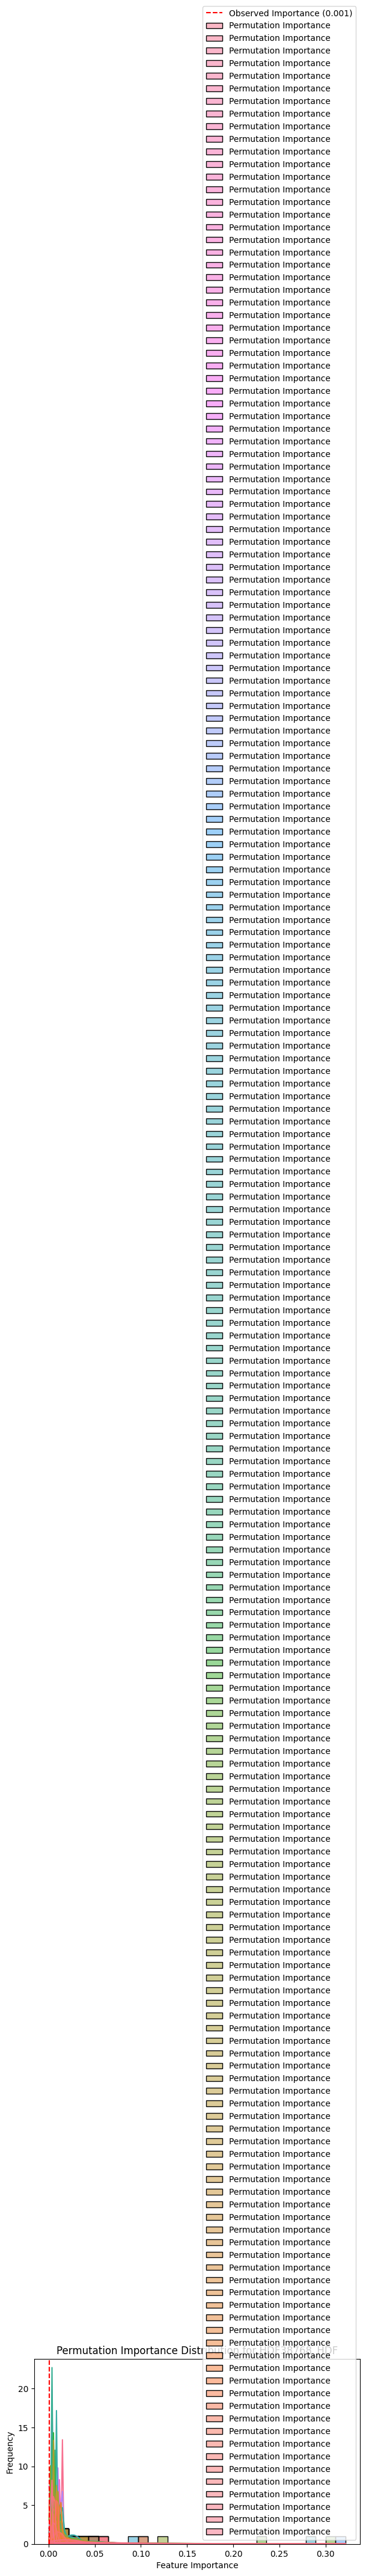

In [72]:
# don't touch this coding!
df_pval, df_null = feature_importance_permutation_test(
    model=model,
    whole_dataset=whole_dataset,
    n_permutations=200,           
    steps_or_samples=10,
    batch_size=32,
    early_stop_patience=4,
    n_iter=5
)

print(df_pval.head())


In [78]:
df_pval

,feature,obs_importance,p_value
0,HDF38768_HDF,0.000864,0.995
1,HDF38296_HDF,0.001224,0.995
2,HDF57814_HDF,0.001412,0.995
3,HDF48762_HDF,0.001224,1.000
4,HDF52603_HDF,0.003976,0.905
...,...,...,...
5425,BM0159_BM,0.001469,0.995
5426,BM0160_BM,0.001462,0.995
5427,BM0161_BM,0.001077,1.000
5428,BM0162_BM,0.001424,1.000


In [74]:
import os

# 指定保存路径
save_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\results"

# 确保目录存在
os.makedirs(save_dir, exist_ok=True)

# 保存 df_pval
df_pval.to_csv(os.path.join(save_dir, "df_pval.csv"), index=False)

# 保存 df_null
df_null.to_csv(os.path.join(save_dir, "df_null.csv"), index=False)


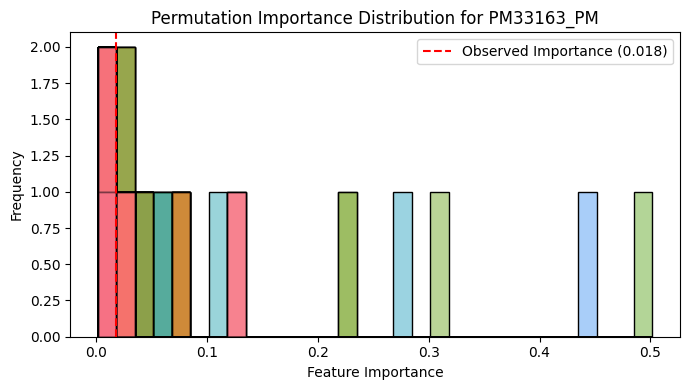

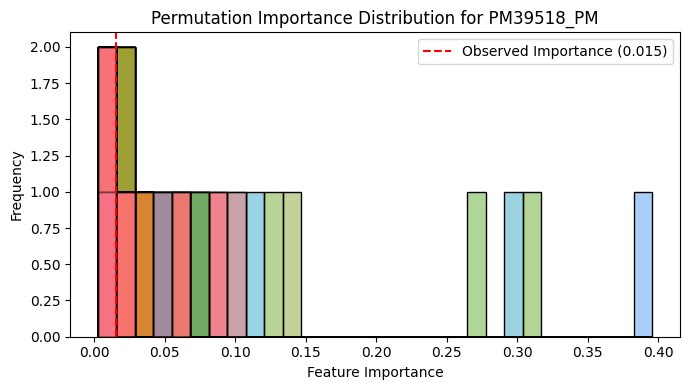

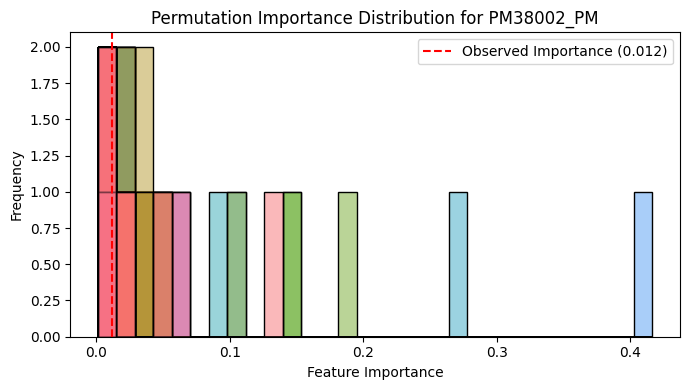

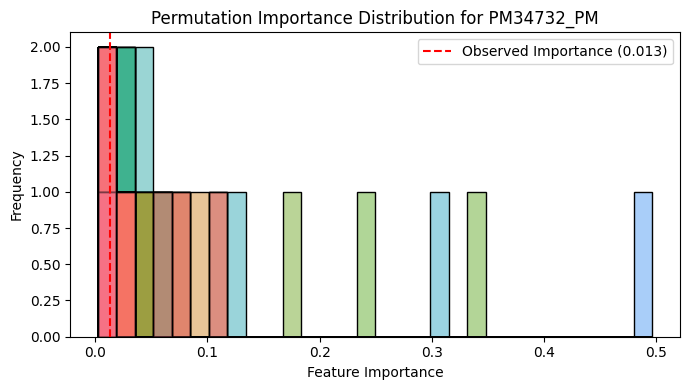

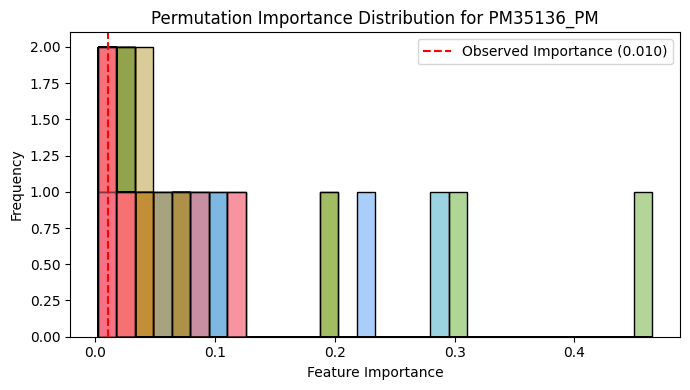

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_permutation_distribution(
    df_pval,
    df_null,
    feature_name,
    bins=30,
    figsize=(7, 4)
):
    if feature_name not in df_null.index:
        raise ValueError(f"Feature '{feature_name}' not found in permutation results.")
    obs_value = df_pval.loc[df_pval['feature'] == feature_name, 'obs_importance'].values[0]
    null_dist = df_null.loc[feature_name]

    plt.figure(figsize=figsize)
    sns.histplot(null_dist, bins=bins, kde=False, color='green')
    plt.axvline(obs_value, color='red', linestyle='--', label=f'Observed Importance ({obs_value:.3f})')
    plt.title(f'Permutation Importance Distribution for {feature_name}')
    plt.xlabel('Feature Importance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()



features_to_plot = [
    "PM33163_PM",
    "PM39518_PM",
    "PM38002_PM",
    "PM34732_PM",
    "PM35136_PM",
]

# 逐个画图
for feature in features_to_plot:
    plot_feature_permutation_distribution(df_pval, df_null, feature)


In [ ]:
# Data check